In [1]:


import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth

# 월 차트 로드
print("Fetching month chart...")

begin = YearMonth(2014, 4)
end = YearMonth(2023, 9)

month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    """,
    maria_home()
)

print("Loading financial data...")
fs_loader = FsLoader()

# matplot 셋업
font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

Fetching month chart...
Loading financial data...


In [2]:
from utils.timeutil import YearMonth, YearQtr

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["open"] > 0]
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상
    df2.loc[df2["open"] == 0, "close"] = round(df2[df2["open"] == 0]["close"] / 2)
    df2.loc[df2["val_last"] == 0, "close"] = round(df2[df2["val_last"] == 0]["close"] / 2)
    # fixme: df1에는 있는데, df2에는 없으면, 거래정지 또는 상장폐지

    df = pd.DataFrame({
        "종목명": df1["name"],
        "매수년월": ym1, "매도년월": ym2,
        "매수일": df1["date"], "매수가": df1["close"],
        "시가총액": df1["cap"], "거래량": df1["vol"], "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1
    })

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

    df["매도가"] = df2["close"]
    df["매도일"] = df2["date"]
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1

,code,종목명,매수년월,매도년월,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,O_QoQ,E_QoQ,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,950130,엑세스바이오,2014-04,2014-05,2014-04-30,11000,298254000000,11140311,121905957210,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,088980,맥쿼리인프라,2014-04,2014-05,2014-04-30,6400,2121339782400,6206195,39649656980,-0.013867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,064260,다날,2014-04,2014-05,2014-04-30,10100,206336303700,19577010,216098583470,-0.133047,...,1.398965,1.134454,-0.294702,-1.190887,-0.294702,-1.190887,0.010806,0.040526,0.049618,0.189951
3,054050,농우바이오,2014-04,2014-05,2014-04-30,24600,351780000000,3054898,77917848050,-0.040936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001810,무림SP,2014-04,2014-05,2014-04-30,3135,69401062500,6101825,18670972805,0.144161,...,-0.769949,-0.910792,-0.353057,-0.587901,-0.048681,-0.081075,-0.024109,-0.039809,-0.020807,-0.034172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190925,042670,HD현대인프라코어,2023-08,2023-09,2023-08-31,10530,2101824360090,47477572,510731833350,-0.154217,...,2.631597,2.922384,0.296806,0.663152,0.083920,0.196821,0.047602,0.117552,0.035074,0.087296
190926,054620,APS,2023-08,2023-09,2023-08-31,8380,170903571980,13621792,144890897040,-0.017585,...,-2.157330,-0.941337,0.018448,0.028930,0.002777,0.003343,-0.025004,-0.040962,-0.015548,-0.028815
190927,154040,다산솔루에타,2023-08,2023-09,2023-08-31,2180,39131204920,21401200,48615828270,-0.022422,...,-1.428332,-3.438672,0.249690,0.684408,0.023648,0.047439,-0.013781,-0.055752,-0.082106,-0.305946
190928,424980,마이크로투나노,2023-08,2023-09,2023-08-31,18700,110683243000,1694084,31405080650,-0.062187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += ["P"]

layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
layer2["R/P"] = layer2["R/Y"] / layer2["P"]
layer2["GP/P"] = layer2["GP/Y"] / layer2["P"]
layer2["O/P"] = layer2["O/Y"] / layer2["P"]
layer2["E/P"] = layer2["E/Y"] / layer2["P"]
factors += ["EQ/P", "R/P", "GP/P", "O/P", "E/P"]

layer2["R/A"] = layer2["R/Y"] / layer2["A"]
layer2["GP/A"] = layer2["GP/Y"] / layer2["A"]
layer2["O/A"] = layer2["O/Y"] / layer2["A"]
layer2["E/A"] = layer2["E/Y"] / layer2["A"]
factors += ["R/A", "GP/A", "O/A", "E/A"]

layer2["R/EQ"] = layer2["R/Y"] / layer2["EQ"]
layer2["GP/EQ"] = layer2["GP/Y"] / layer2["EQ"]
layer2["O/EQ"] = layer2["O/Y"] / layer2["EQ"]
layer2["E/EQ"] = layer2["E/Y"] / layer2["EQ"]
factors += ["R/EQ", "GP/EQ", "O/EQ", "E/EQ"]

layer2["GP/A"] = layer2["GP/Y"] / layer2["A"]
factors += ["GP/A"]

layer2["GP/A/P"] = layer2["GP/Y"] / layer2["A"] / layer2["P"]
factors += ["GP/A/P"]

layer2["GPGP/A"] = layer2["GP/Y"] ** 2 / layer2["A"]
factors += ["GPGP/A"]

layer2["GPGP/A/P"] = layer2["GP/Y"] ** 2 / layer2["A"] / layer2["P"]
factors += ["GPGP/A/P"]

recipes = {
    "개사기": {
        "GP/A/P": 1,
        "P": -1
    },
    "벨류": {
        "EQ/P": 1,
        "GP/P": 1,
    },
    "벨류2": {
        "EQ/P": 1,
        "GP/P": 1,
        "GP/A/P": 1
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
        "R/EQ_QoQ": 0.028347,
        "R_QoQ": 0.022196,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
    },
    "전략2": {
        "P": -1,
        "벨류2": 1,
        "성장": 1,
    },
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    for title, recipe in recipes.items():
        # df[title] = pd.concat(
        #     [(df[f"{k}_pct"] if w > 0 else 1 / df[f"{k}_pct"]) ** abs(w) for k, w in recipe.items()],
        #     axis=1
        # ).prod(axis=1, skipna=False)
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-09

,code,종목명,매수년월,매도년월,매수일,매수가,P,거래량,TV,전월수익률,...,벨류,벨류_pct,벨류2,벨류2_pct,성장,성장_pct,전략,전략_pct,전략2,전략2_pct
0,950130,엑세스바이오,2014-04,2014-05,2014-04-30,11000,298254000000,11140311,121905957210,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,088980,맥쿼리인프라,2014-04,2014-05,2014-04-30,6400,2121339782400,6206195,39649656980,-0.013867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,064260,다날,2014-04,2014-05,2014-04-30,10100,206336303700,19577010,216098583470,-0.133047,...,1496.0,40.0,103224.0,53.0,54.749378,42.0,26.250000,36.0,34.781250,46.0
3,054050,농우바이오,2014-04,2014-05,2014-04-30,24600,351780000000,3054898,77917848050,-0.040936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001810,무림SP,2014-04,2014-05,2014-04-30,3135,69401062500,6101825,18670972805,0.144161,...,7857.0,94.0,502848.0,94.0,72.987198,54.0,181.285714,85.0,181.285714,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190925,042670,HD현대인프라코어,2023-08,2023-09,2023-08-31,10530,2101824360090,47477572,510731833350,-0.154217,...,4212.0,68.0,71604.0,44.0,157.701526,98.0,71.655914,60.0,46.365591,49.0
190926,054620,APS,2023-08,2023-09,2023-08-31,8380,170903571980,13621792,144890897040,-0.017585,...,1768.0,44.0,44200.0,36.0,33.984930,23.0,20.240000,30.0,16.560000,28.0
190927,154040,다산솔루에타,2023-08,2023-09,2023-08-31,2180,39131204920,21401200,48615828270,-0.022422,...,5460.0,78.0,513240.0,92.0,32.530800,22.0,343.200000,93.0,404.800000,93.0
190928,424980,마이크로투나노,2023-08,2023-09,2023-08-31,18700,110683243000,1694084,31405080650,-0.062187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[6/6] 전략22014-04 2023-09
           개사기   벨류  벨류2        성장   전략  전략2
GP/A/P     1.0  NaN  1.0       NaN  NaN  NaN
P         -1.0  NaN  NaN       NaN -1.0 -1.0
EQ/P       NaN  1.0  1.0       NaN  NaN  NaN
GP/P       NaN  1.0  1.0       NaN  NaN  NaN
GP/A_QoQ   NaN  NaN  NaN  0.142706  NaN  NaN
O/A_QoQ    NaN  NaN  NaN  0.130182  NaN  NaN
GP/EQ_QoQ  NaN  NaN  NaN  0.129825  NaN  NaN
O/EQ_QoQ   NaN  NaN  NaN  0.118514  NaN  NaN
E/EQ_QoQ   NaN  NaN  NaN  0.111300  NaN  NaN
O_QoQ      NaN  NaN  NaN  0.098340  NaN  NaN
E_QoQ      NaN  NaN  NaN  0.097314  NaN  NaN
GP_QoQ     NaN  NaN  NaN  0.083276  NaN  NaN
R/A_QoQ    NaN  NaN  NaN  0.082624  NaN  NaN
E/A_QoQ    NaN  NaN  NaN  0.079270  NaN  NaN
R/EQ_QoQ   NaN  NaN  NaN  0.028347  NaN  NaN
R_QoQ      NaN  NaN  NaN  0.022196  NaN  NaN
벨류         NaN  NaN  NaN       NaN  1.0  NaN
성장         NaN  NaN  NaN       NaN  1.0  1.0
벨류2        NaN  NaN  NaN       NaN  NaN  1.0


,spearman,kendall,h5,h10,t5,t10,mdd5,h10-t10,mean,median,strength
전략,0.903738,0.740606,0.355534,0.339350,-0.097728,-0.092992,-0.318519,0.432341,0.060292,0.044584,0.390724
전략2,0.908035,0.752727,0.384360,0.340776,-0.125068,-0.087777,-0.322610,0.428553,0.060934,0.031802,0.389141
개사기,0.820966,0.643636,0.422748,0.327642,-0.062208,-0.052666,-0.322049,0.380308,0.059878,0.030017,0.312220
벨류2,0.833243,0.641212,0.225726,0.195624,-0.055823,-0.066625,-0.345936,0.262249,0.057684,0.061111,0.218517
성장,0.759988,0.574141,0.147457,0.148681,-0.010702,-0.018767,-0.421133,0.167447,0.056605,0.049006,0.127258
벨류,0.720540,0.532929,0.106412,0.128186,-0.075536,-0.047391,-0.464174,0.175577,0.055453,0.062136,0.126510


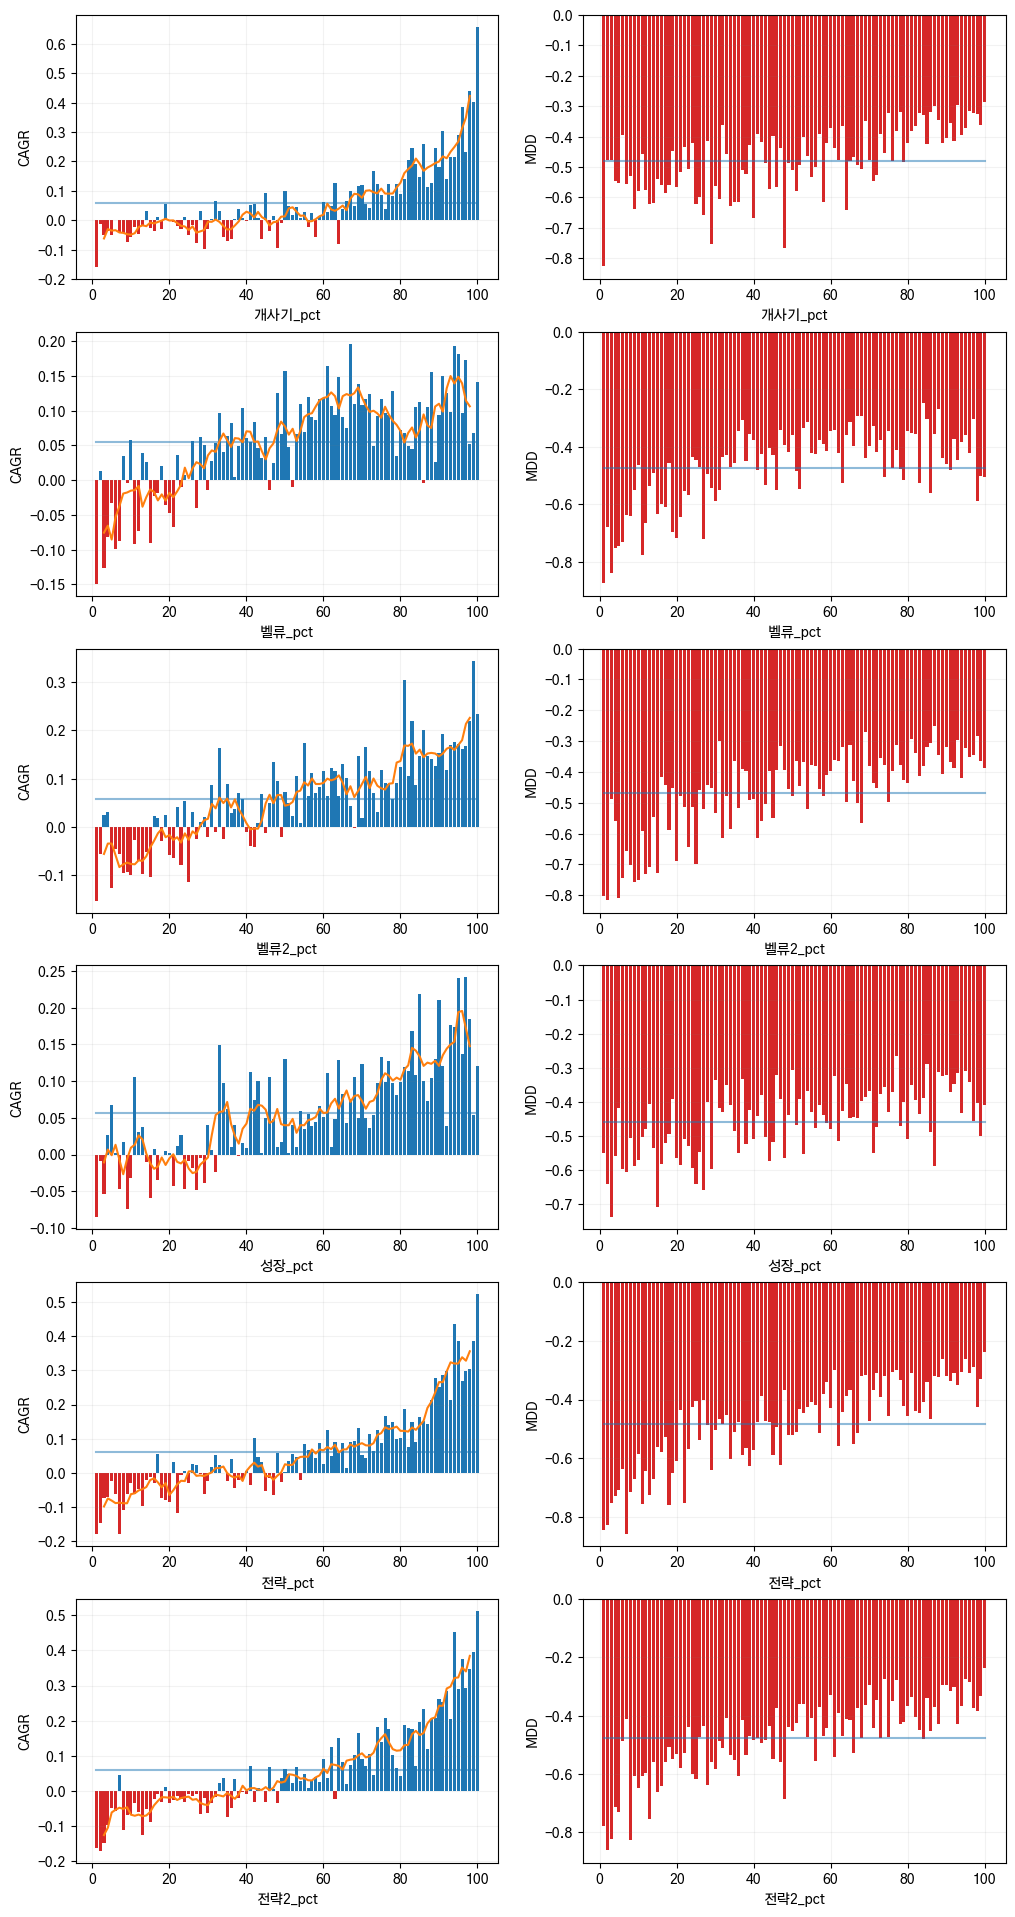

In [4]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(12), fig.set_figheight(4 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary = summary.sort_values(by="strength", ascending=False)
summary

In [11]:
# 백테스트: 매매 시뮬레이션

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

head = 20
strategy = result2.dropna().groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["벤치마크 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "전월수익률", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")
result3

전략
          CAGR                                         MDD      Mean
전략    0.534822  (-0.25803546518371967, (2019-12, 2020-03))  0.040189
벤치마크  0.056935  (-0.37165379476403493, (2018-05, 2020-03))  0.006509


code     종목명       수익률         매수일         매도일  \
매수년월    매도년월                                                               
2014-04 2014-05 146     038010  제일테크노스  0.216837  2014-04-30  2014-05-30   
                722     054940   엑사이엔씨  0.215470  2014-04-30  2014-05-30   
                583     024940    PN풍년  0.103774  2014-04-30  2014-05-30   
                989     003310    대주산업  0.029008  2014-04-30  2014-05-30   
                73      005110      한창  0.026756  2014-04-30  2014-05-30   
...                        ...     ...       ...         ...         ...   
2023-08 2023-09 190046  071950     코아스 -0.133436  2023-08-31  2023-09-27   
                190014  103230  에스앤더블류 -0.147002  2023-08-31  2023-09-27   
                188966  053060      세동 -0.158392  2023-08-31  2023-09-27   
                190513  106240  파인테크닉스 -0.166586  2023-08-31  2023-09-27   
                189686  054630   에이디칩스 -0.169014  2023-08-31  2023-09-27   

                          매수가      매도가     전월수익률  P_pct  성장_pct  벨류_pct  \
매수년월    매도년월                                                              
2014-04 2014-05 146     19600  23850.0  0.091922    2.0    33.0    98.0   
                722       905   1100.0  0.102314    3.0    53.0    98.0   
                583      2120   2340.0  0.168044    3.0    94.0    92.0   
                989       655    674.0  0.110169    3.0    66.0    95.0   
                73        598    614.0  0.297180    2.0    69.0    84.0   
...                       ...      ...       ...    ...     ...     ...   
2023-08 2023-09 190046    652    565.0 -0.094444    1.0    31.0    72.0   
                190014   5170   4410.0 -0.065099    3.0    91.0    63.0   
                188966   2115   1780.0 -0.088362    4.0   100.0    74.0   
                190513   2065   1721.0 -0.041763    2.0    66.0    90.0   
                189686    355    295.0 -0.070681    1.0    38.0    52.0   

                        전략_pct  
매수년월    매도년월                    
2014-04 2014-05 146       99.0  
                722      100.0  
                583      100.0  
                989      100.0  
                73       100.0  
...                        ...  
2023-08 2023-09 190046   100.0  
                190014   100.0  
                188966    99.0  
                190513   100.0  
                189686   100.0  

[2260 rows x 12 columns]

In [12]:
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2014-04,2014-05,-0.009257,0.000766,0.01,0.990743,1.000766
2014-05,2014-06,-0.009508,-0.004533,0.00,0.981323,0.996230
2014-06,2014-07,0.017540,0.081450,0.06,0.998536,1.077373
2014-07,2014-08,0.039669,0.084187,0.04,1.038147,1.168075
2014-08,2014-09,0.009812,0.049449,0.04,1.048333,1.225834
...,...,...,...,...,...,...
2023-04,2023-05,0.035096,0.024165,-0.01,1.808172,64.379988
2023-05,2023-06,0.007393,-0.013982,-0.02,1.821541,63.479833
2023-06,2023-07,-0.029288,-0.019912,0.01,1.768192,62.215850


total          113.000000
out-perform     78.000000
승률               0.690265
누적 성능           36.066235
dtype: float64

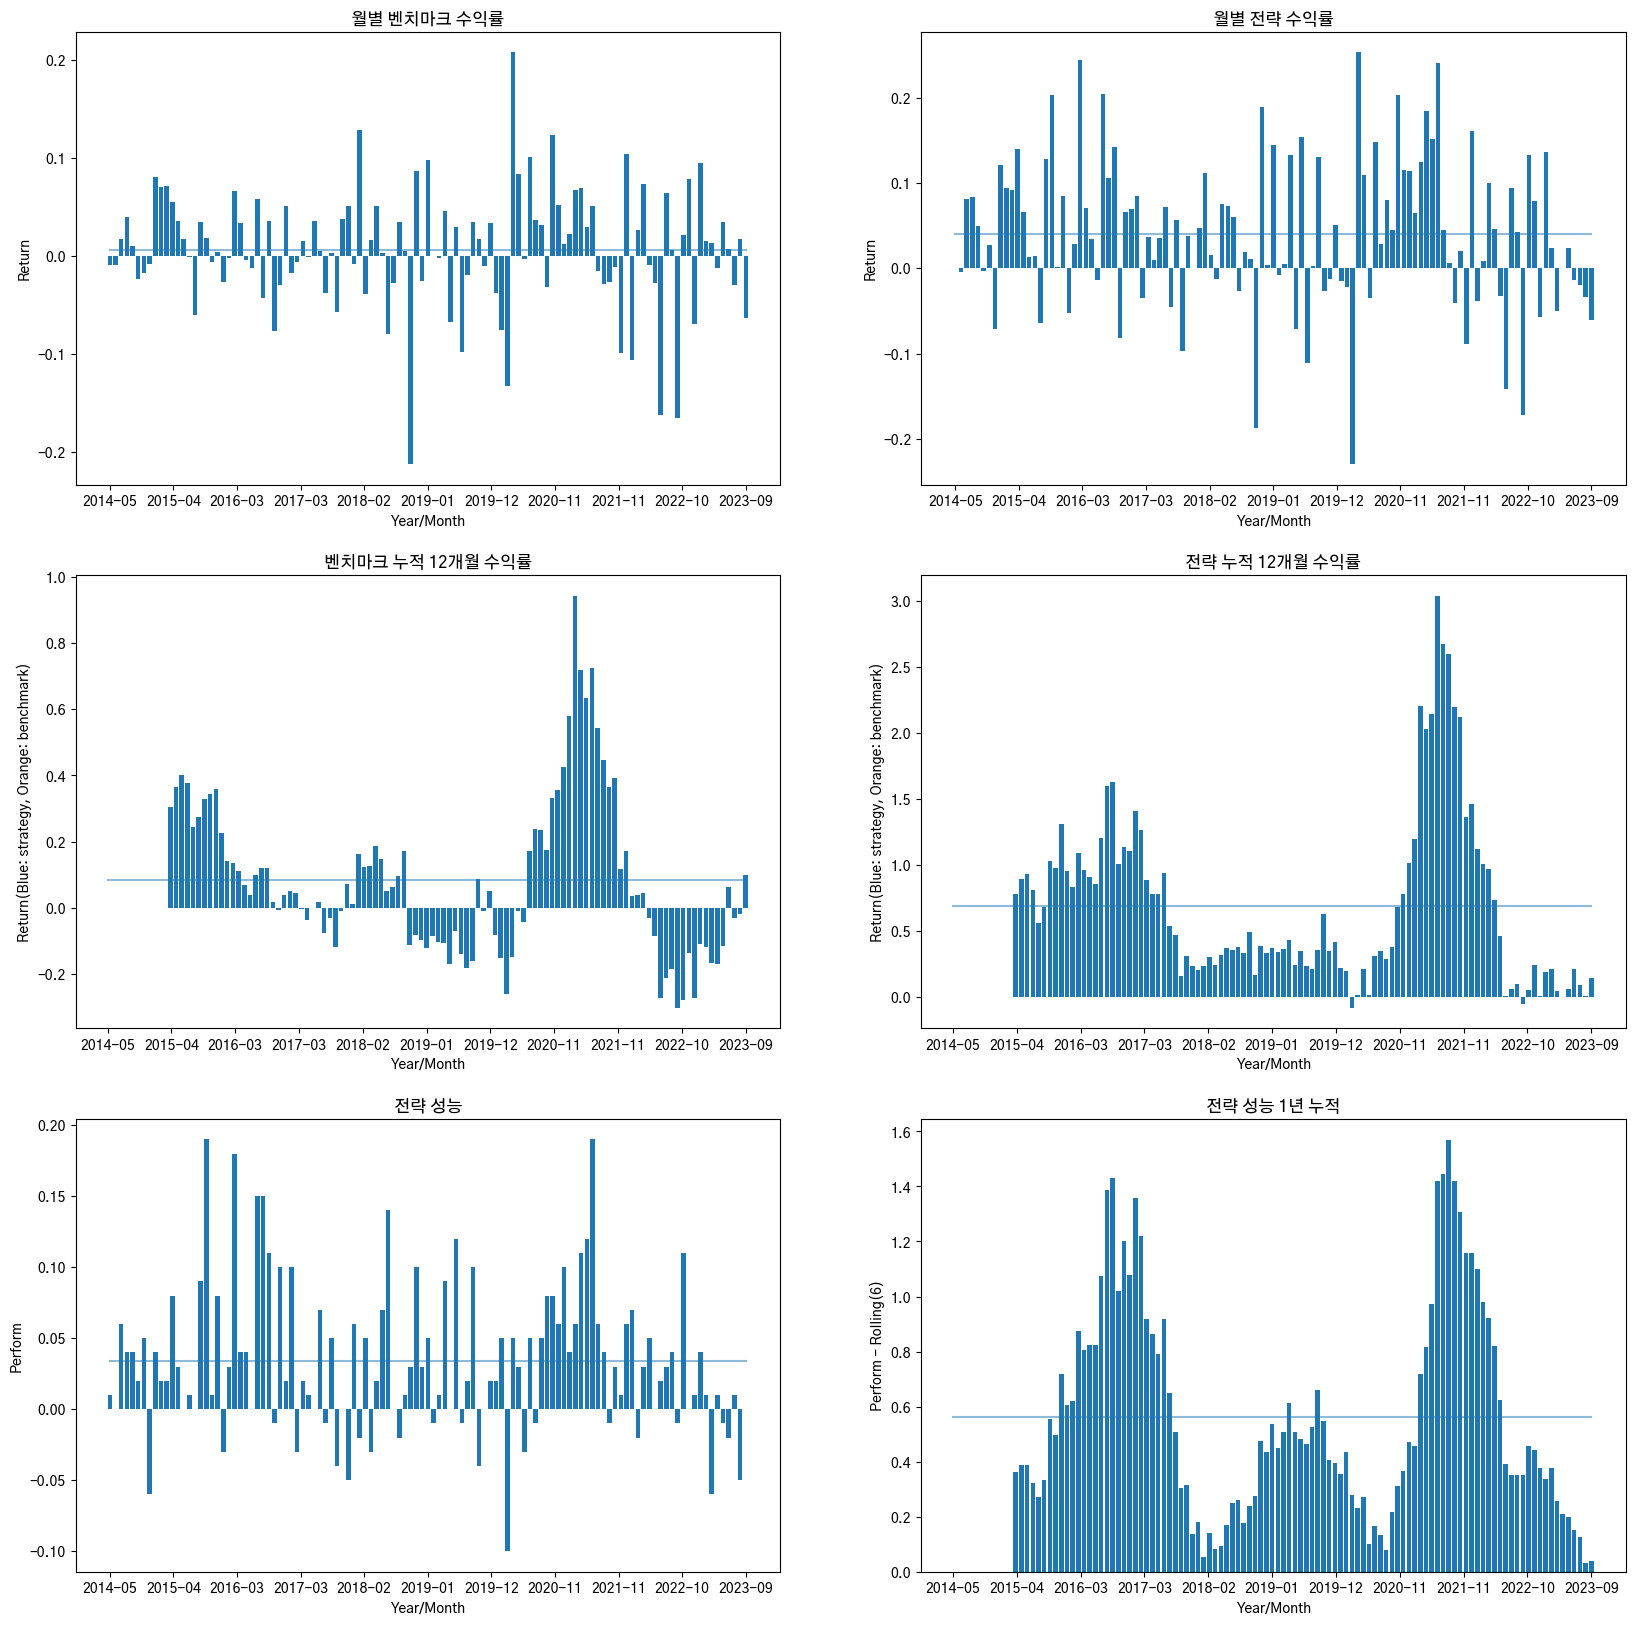

In [13]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": len(revisions[revisions["성능"] > 0]),
    "승률": len(revisions[revisions["성능"] > 0]) / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})